# Time Series Forecasting 

Generate Data with linear trend with a cyclic pattern and random noise

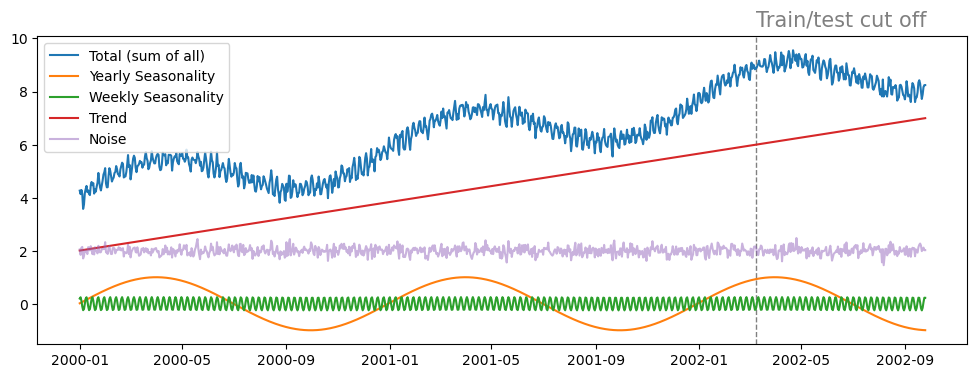

In [224]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL, MSTL
import lightgbm as lgb

plt.rcParams['figure.figsize'] = (12, 4)
rng = np.random.default_rng(42)
t = np.arange(1, 1000)
df = pd.DataFrame({
    'yearly_seasonality': np.sin(2*np.pi*t / 365),
    'weekly_seasonality': 0.25*np.sin(2*np.pi*t / 365*52),
    'trend': 2+t*.005,
    'noise': rng.normal(2, scale=0.15, size=len(t)),
},
    index=pd.date_range(start='2000-01-01', periods=len(t), freq='D')
)
df['total'] = df['yearly_seasonality'] + df['weekly_seasonality'] + df['trend'] + df['noise']

train_cutoff = int(len(df) * 0.8)
target_df = df.loc[:, 'total']
train, test = target_df.iloc[:train_cutoff], target_df.iloc[train_cutoff:]

def plot_df(df, train):
    plt.axvline(x=train.index[-1], color='gray', linestyle='--', linewidth=1)
    plt.text(train.index[-1], train.max()+2, 'Train/test cut off',
        color='gray', fontsize=15, va='top', ha='left')

    plt.plot(df['total'], label='Total (sum of all)')
    plt.plot(df['yearly_seasonality'], label='Yearly Seasonality')
    plt.plot(df['weekly_seasonality'], label='Weekly Seasonality')
    plt.plot(df['trend'], label='Trend')
    plt.plot(df['noise'], label='Noise', alpha=.5)
    plt.legend()
    plt.show()

plot_df(df, train)

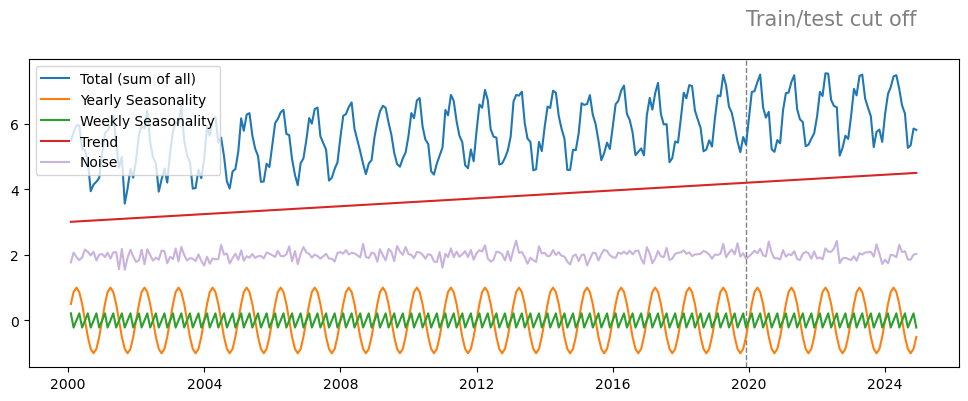

In [228]:
# Resampling was a bit too naive and lost all of the noise in the dataset.
# monthly_df = df.resample('ME').mean().iloc[1:-1] # Remove the first and last points for a pretty plot

t = np.arange(1, 300)
monthly_df = pd.DataFrame({
    'yearly_seasonality': np.sin(2*np.pi*t / 12),
    'weekly_seasonality': 0.25*np.sin(2*np.pi*t / 12*52),
    'trend': 3+t*0.005,
    'noise': rng.normal(2, scale=0.15, size=len(t)),
},
    index=pd.date_range(start='2000-01-01', periods=len(t), freq='ME')
)
monthly_df['total'] = monthly_df['yearly_seasonality'] + monthly_df['weekly_seasonality'] + monthly_df['trend'] + monthly_df['noise']

monthly_train_cutoff = int(len(monthly_df) * 0.8)
monthly_target_df = monthly_df.loc[:, 'total']
monthly_train, monthly_test = monthly_target_df.iloc[:monthly_train_cutoff], monthly_target_df.iloc[monthly_train_cutoff:]

plot_df(monthly_df, monthly_train)

## Stationary
A time series is stationary if it does not exhibit any long term trends or obvious seasonality. It must have:
- constant variance through time
- constant mean through time

Differencing can help stabilize the mean of a time series by removing changes in the level of a time series, and so eliminating trends. This can also remove seasonality, if differences are taken appropriately (e.g. differencing observations 1 year apart to remove a yearly trend).

### Augmented Dickey-Fuller
We can use the Augmented Dickey-Fuller (ADF) test to test if the data is stationary. A p-value below 0.05 and a test statistic less than the critical value at the 5% significance level, indicates that the data is stationary at the 5% significance level.

In [4]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

adf_test(train)

print('\nWith differencing:')
adf_test(train.diff().iloc[1:])

Results of Dickey-Fuller Test:
Test Statistic                   0.231933
p-value                          0.973997
#Lags Used                      18.000000
Number of Observations Used    780.000000
Critical Value (1%)             -3.438761
Critical Value (5%)             -2.865253
Critical Value (10%)            -2.568747
dtype: float64

With differencing:
Results of Dickey-Fuller Test:
Test Statistic                  -4.108587
p-value                          0.000937
#Lags Used                      21.000000
Number of Observations Used    776.000000
Critical Value (1%)             -3.438805
Critical Value (5%)             -2.865272
Critical Value (10%)            -2.568757
dtype: float64


### ACF (Autocorrelation Function) 
ACF measures the correlation between the time series and its lagged values. 

ACF is useful for identifying **MA (Moving Average)** components in time series models. If the ACF cuts off after a certain lag (e.g., drops to zero), it suggests that the series can be modeled by an MA process up to that lag.

### PACF (Partial Autocorrelation Function)
PACF measures the correlation between the time series and its lagged values, **but removes the influence of intermediate lags**.

It provides the pure or "partial" correlation at each lag, controlling for the effects of previous lags.

PACF is useful for identifying **AR (Autoregressive)** components. A cut-off in the PACF indicates the order of the AR model to use (i.e., how many past terms are needed to explain the current observation).

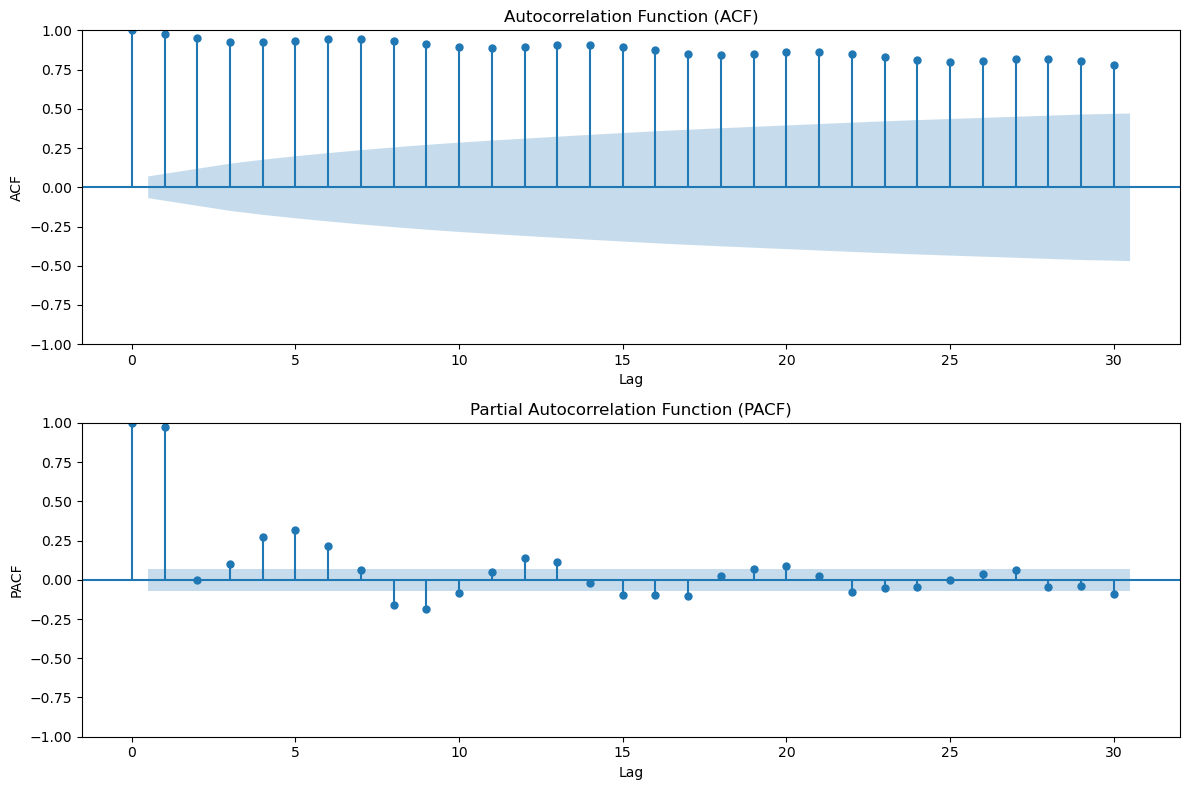

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(train, lags=30, ax=axs[0])
axs[0].set_title('Autocorrelation Function (ACF)')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF')

plot_pacf(train, lags=30, ax=axs[1])
axs[1].set_title('Partial Autocorrelation Function (PACF)')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('PACF')

plt.tight_layout()
plt.show()

### Seasonal-Trend decomposition

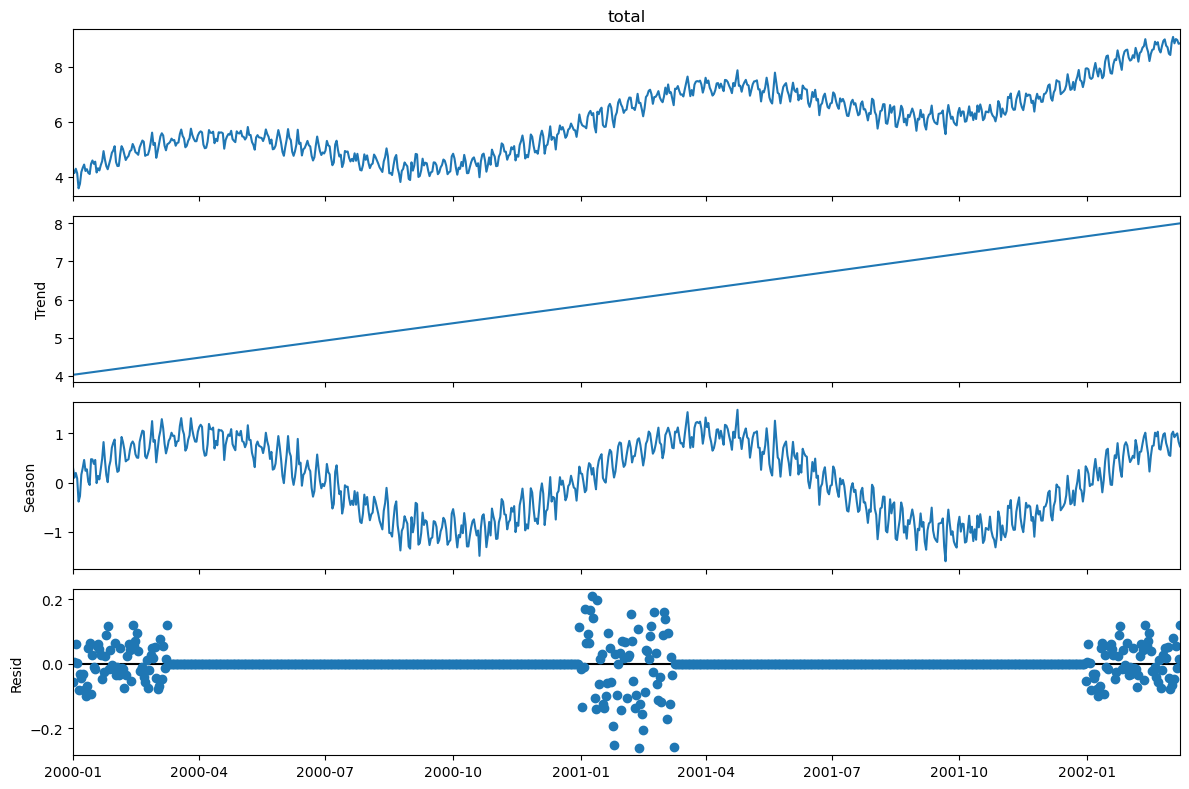

In [6]:
plt.rcParams['figure.figsize'] = (12, 8)
stl = STL(train, period=365)
res = stl.fit()
fig = res.plot()

### Multiple Seasonal-Trend decomposition [[docs](https://www.statsmodels.org/dev/examples/notebooks/generated/mstl_decomposition.html)]

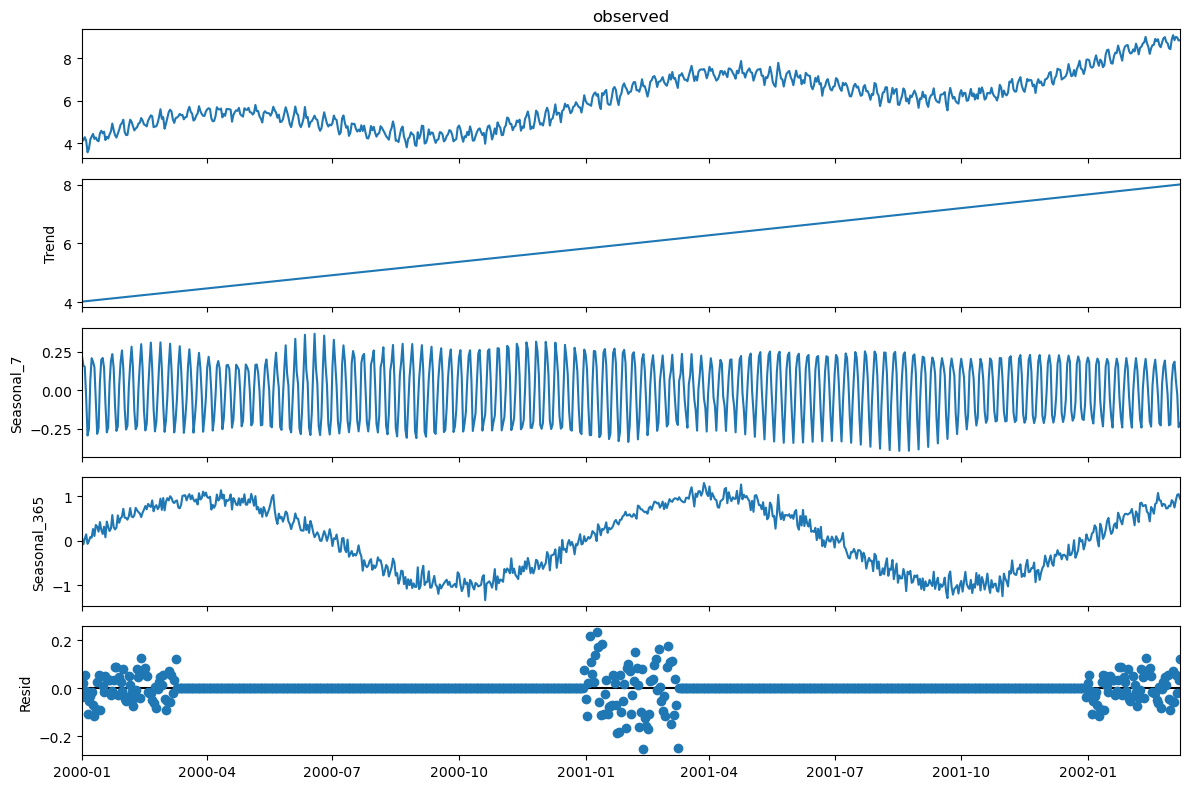

In [7]:
mstl = MSTL(train, periods=[7, 365])
res = mstl.fit()
fig = res.plot()

## Modeling 
### Exponential Smoothing <a name="Exponential-Smoothing"></a>
$ S_t = \alpha  y_t + (1 - \alpha) S_{t-1} $, where
- $ S_t $ is the smoothed value at time $ t $
- $ y_t $ is the actual value at time $ t $
- $ \alpha $ is the smoothing parameter, $ 0 \leq \alpha \leq 1 $

<br>
Simple exponential smoothing won't be able to capture any of the trends on the data :(

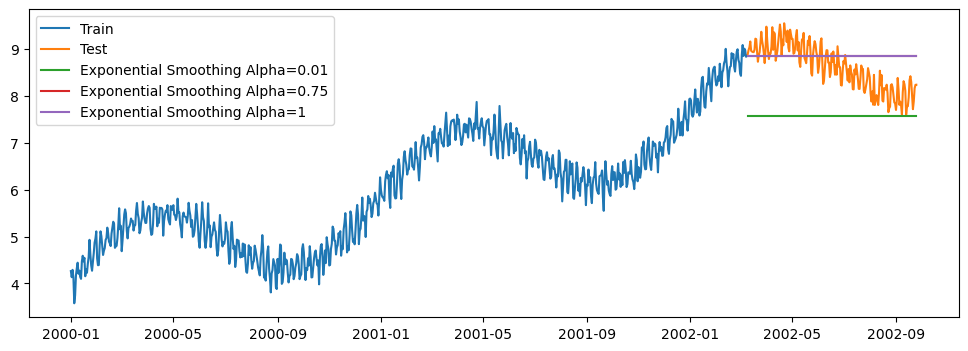

In [8]:
plt.rcParams['figure.figsize'] = (12, 4)

plt.plot(train, label='Train')
plt.plot(test, label='Test')

for alpha in [0.01, 0.75, 1]:
    exp_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha, optimized=False)
    exp_smoothing_forecast = exp_model.forecast(len(test))
    plt.plot(test.index, exp_smoothing_forecast, label=f'Exponential Smoothing Alpha={alpha}')

plt.legend()
plt.show()

#### Exponential smoothing with seasonality (Holt-Winters)


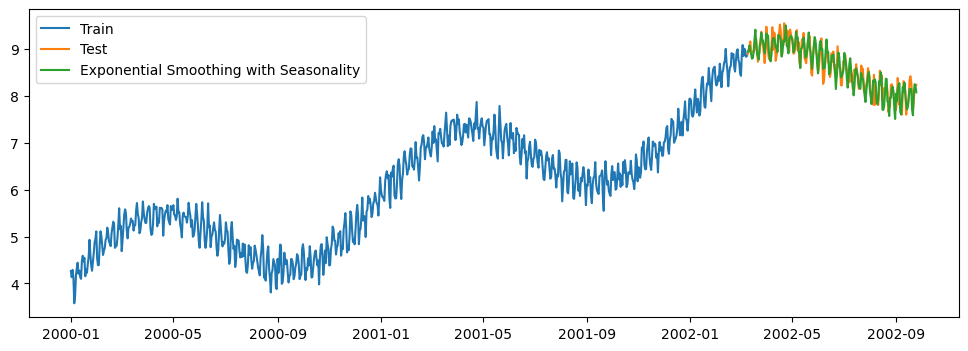

In [9]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')

exp_model = ExponentialSmoothing(
    train,
    seasonal_periods=365,
    trend="add",
    seasonal="add",
).fit()
exp_smoothing_forecast = exp_model.forecast(len(test))

plt.plot(test.index, exp_smoothing_forecast, label=f'Exponential Smoothing with Seasonality')
plt.legend()
plt.show()

#### Model decomposition

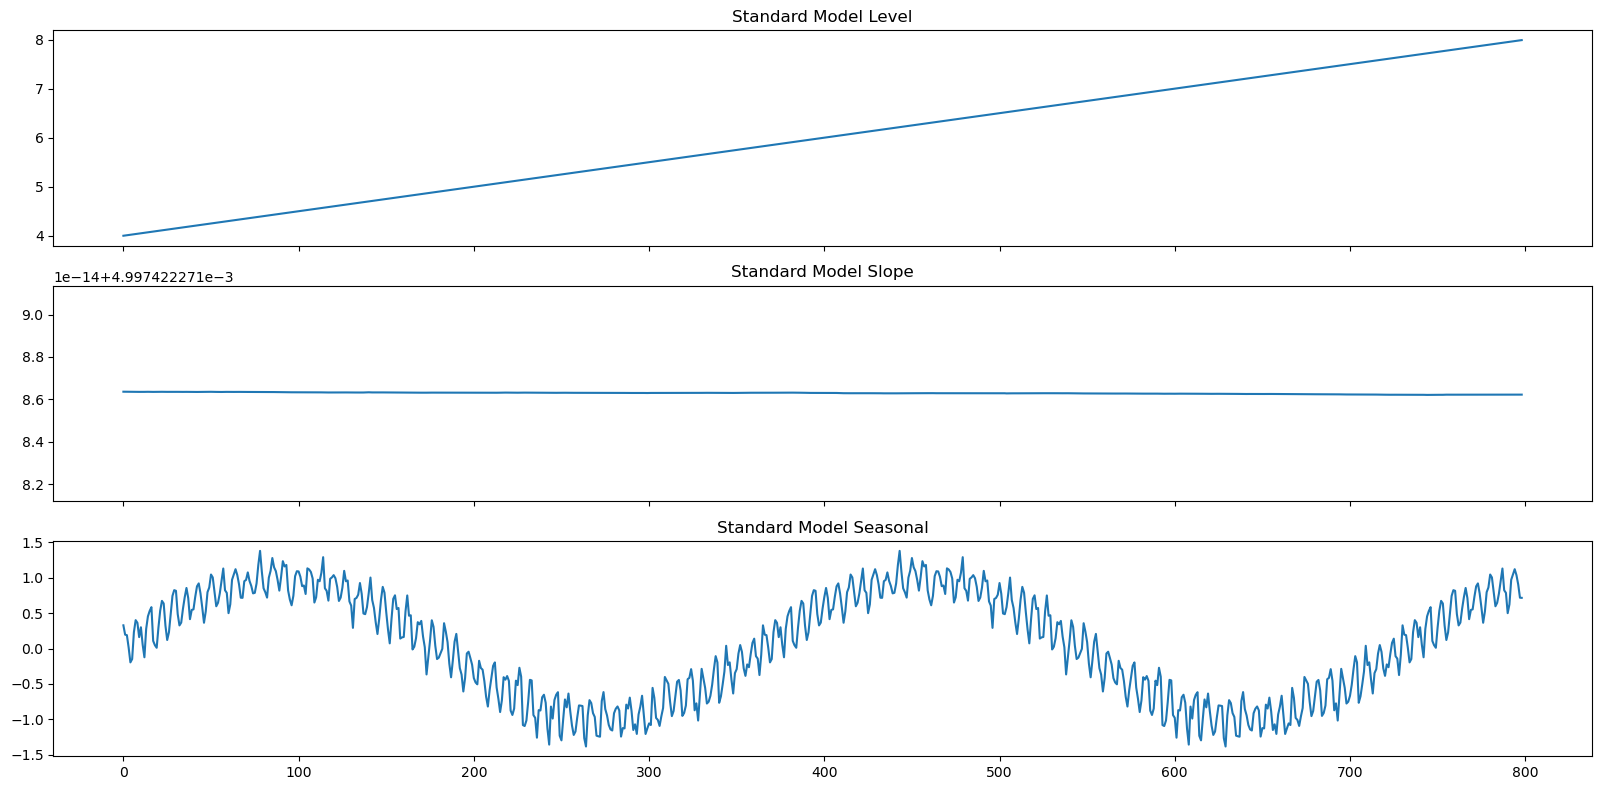

In [12]:
exp_model = ExponentialSmoothing(
    train,
    seasonal_periods=365,
    trend="add",
    seasonal="add"
).fit()

states = pd.DataFrame(
    np.c_[exp_model.level, exp_model.trend, exp_model.season],
    columns=["level", "slope", "seasonal"]
)

fig, axes = plt.subplots(3, 1, figsize=(16, 8), sharex=True)
states[["level"]].plot(ax=axes[0], title="Standard Model Level", legend=False)
states[["slope"]].plot(ax=axes[1], title="Standard Model Slope", legend=False)
states[["seasonal"]].plot(ax=axes[2], title="Standard Model Seasonal", legend=False)
plt.tight_layout()
plt.show()

### ARIMA / SARIMAX(p, d, q)x(P, D, Q, s) <a name="ARIMA"></a>

Parameters:
* **AutoRegressive (p)**: Relationship between an observation and a certain number of lagged observations (previous time steps). The parameter p determines the number of lag observations included in the model.
* **Integrated (d)**: Order of differencing required to make the series stationary. Differencing is the transformation of a time series to remove trends and seasonality, and d is the number of times the differencing operation is performed.
* **Moving Average (q)**: Relationship between an observation and a residual error from a moving average model applied to lagged observations. The parameter q specifies the number of terms.

Seasonal components:
* **Seasonal AR (P)**: Similar to the AR but apply to the seasonal component of the series. The parameter P specifies the number of seasonal autoregressive terms.
* **Seasonal differencing order (D)**: How many seasonal differences are needed to make the series stationary.
* **Seasonal MA (Q)**: MA for the seasonal differences. Q specifies the number of seasonal moving average terms.
* **Seasonal period (s)**: Length of the seasonal cycle. E.g. s=12 for monthly data with an annual cycle.

Other:
* **Exogenous variables (X)**: External variables that influence the forecast but are not predicted by the model. They can include any variable thought to affect the dependent variable, such as economic indicators, weather conditions, etc.

ARIMA(0,1,1) without constant = simple exponential smoothing


I'm sticking with the monthly dataframe here since daily data is impractical for ARIMA models.

c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: method_kwargs. After release 0.14, this will raise.
  warnings.warn(
c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds

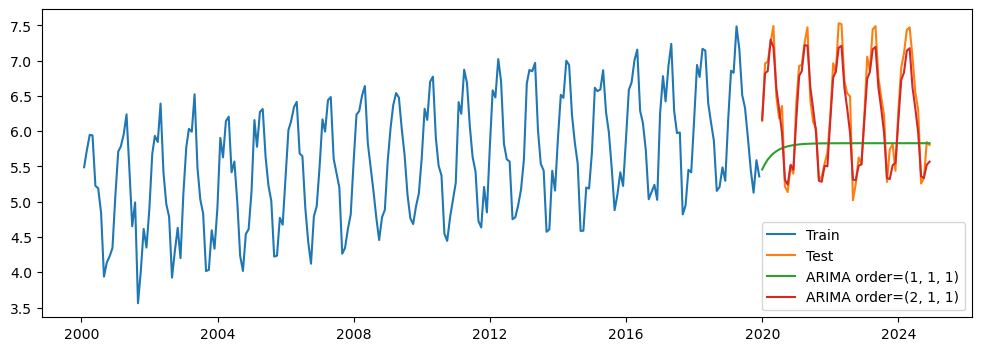

In [231]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found.")

def ARIMA_forecast(model, n_forecast):
    arima_fit = model.fit(method_kwargs={"warn_convergence": False})
    return arima_fit.forecast(n_forecast)

plt.plot(monthly_train, label='Train')
plt.plot(monthly_test, label='Test')
plt.plot(monthly_test.index, ARIMA_forecast(SARIMAX(monthly_train, order=(1, 1, 1)), len(monthly_test)), label='ARIMA order=(1, 1, 1)')
plt.plot(monthly_test.index, ARIMA_forecast(SARIMAX(monthly_train, order=(12, 1, 1)), len(monthly_test)), label='ARIMA order=(12, 1, 1)')
plt.legend()
plt.show()

Tested ARIMA(1, 0, 2)x(0, 0, 1, 24) - AIC:217.9106479240304


c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(1, 1, 2)x(1, 0, 2, 12) - AIC:-149.0432978668419
Tested ARIMA(1, 0, 2)x(0, 1, 0, 24) - AIC:-71.64133951217056


c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Tested ARIMA(1, 0, 0)x(1, 0, 0, 52) - AIC:331.0274412818422


c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Tested ARIMA(0, 0, 0)x(1, 1, 2, 52) - AIC:573.2412013142298


c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Tested ARIMA(0, 0, 1)x(2, 1, 2, 52) - AIC:389.12246674086737


c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Tested ARIMA(2, 0, 0)x(0, 0, 1, 52) - AIC:302.80098750520597


c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Tested ARIMA(2, 0, 1)x(2, 1, 1, 24) - AIC:-147.36497353821534


c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Tested ARIMA(0, 0, 0)x(2, 1, 2, 52) - AIC:512.0348572513847
Tested ARIMA(0, 0, 0)x(1, 1, 0, 24) - AIC:-3.472236811938232

Best Model: ARIMA(1, 1, 2)x(1, 0, 2, 12) - AIC:-149.0432978668419


c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: method_kwargs. After release 0.14, this will raise.
  warnings.warn(
c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ValueError: x and y must have same first dimension, but have shapes (60,) and (200,)

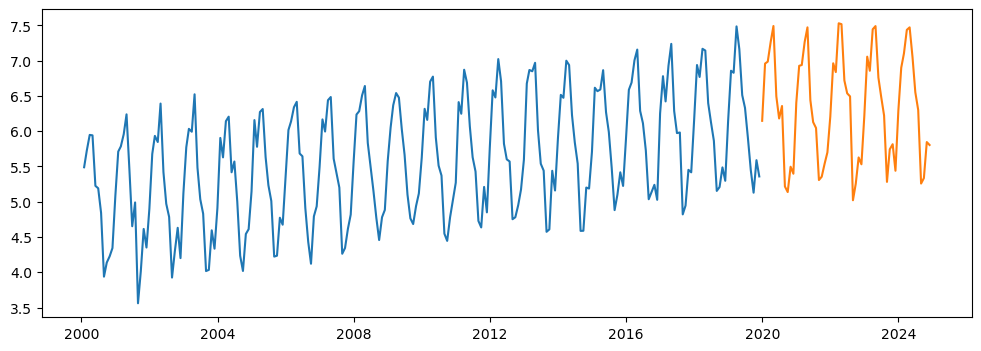

In [232]:
def random_arima_search(train, n_trials=10):
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None
    best_model = None
    
    # Define search space for (p, d, q) and (P, D, Q, m)
    p_values = range(0, 3)
    d_values = range(0, 2)
    q_values = range(0, 3)
    
    P_values = range(0, 3)
    D_values = range(0, 2)
    Q_values = range(0, 3)
    m_values = [12, 24, 52]  # Seasonal periods to try
    
    for _ in range(n_trials):
        # Randomly select order and seasonal_order
        order = (np.random.choice(p_values), np.random.choice(d_values), np.random.choice(q_values))
        seasonal_order = (np.random.choice(P_values), np.random.choice(D_values), np.random.choice(Q_values), np.random.choice(m_values))
        
        try:
            model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
            model_fit = model.fit()
            aic = model_fit.aic
            if aic < best_aic:
                best_aic = aic
                best_order = order
                best_seasonal_order = seasonal_order
                best_model = model
            
            print(f"Tested ARIMA{order}x{seasonal_order} - AIC:{aic}")
        
        except Exception as e:
            # Handle models that fail to converge or encounter errors
            print(f"Failed for ARIMA{order}x{seasonal_order}: {e}")
    
    print(f"\nBest Model: ARIMA{best_order}x{best_seasonal_order} - AIC:{best_aic}")
    return best_model, best_order, best_seasonal_order

# Perform random search
best_model, best_order, best_seasonal_order = random_arima_search(monthly_train)

plt.plot(monthly_train, label='Train')
plt.plot(monthly_test, label='Test')
plt.plot(monthly_test.index, ARIMA_forecast(best_model, len(test)), label=f'Best ARIMA order={best_order}, seasonal_order={best_seasonal_order}')
plt.legend()
plt.show()

### LightGBM <a name="lightgbm"></a>
We can turn the forecasting data into tabular form by creating lag features.


```{warning}
Tree based models cannot make predictions outside of the training data. Below we see the result of this by finding that the model won't predict a value higher than what was previously observed.
```
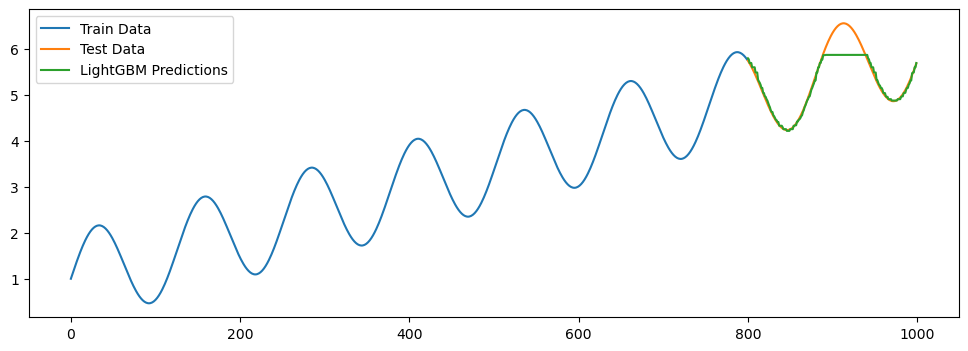

In [ ]:
lgb_train = train.to_frame()
lgb_train = lgb_train.rename(columns={'total': 'y'})

for lag in range(1, 5):
    lgb_train[f't_{lag}'] = lgb_train['y'].shift(lag)

display(lgb_train.head())

X = lgb_train.drop('y', axis=1)
y = lgb_train['y']

In [76]:
'''
Parameter Tuning
'''
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

rng = np.random.default_rng()

param_grid = {
    'boosting_type': ['gbdt', 'dart'],
    'metric': ['l2'],
    'learning_rate': rng.uniform(0.01, .5, 10),
    'num_leaves': rng.integers(2, 100, 10),
    'feature_fraction': rng.uniform(0.25, 1, 10),
    'bagging_fraction': rng.uniform(0.25, 1, 10),
    'lambda_l1': rng.uniform(0.0, 0.5, 10),
    'lambda_l2': rng.uniform(0.0, 0.5, 10),
    'min_gain_to_split': rng.uniform(0.01, 0.25, 10),
    'verbose': [-1]
}

gbm = lgb.LGBMRegressor()
grid_search = HalvingRandomSearchCV(estimator=gbm, param_distributions=param_grid, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

print("Best parameters found by grid search are:", grid_search.best_params_)

Best parameters found by grid search are: {'verbose': -1, 'num_leaves': 55, 'min_gain_to_split': 0.06764624350073846, 'metric': 'l2', 'learning_rate': 0.32486093534861593, 'lambda_l2': 0.35299651007555277, 'lambda_l1': 0.10706850623011366, 'feature_fraction': 0.8261402761937192, 'boosting_type': 'gbdt', 'bagging_fraction': 0.843250629681239}


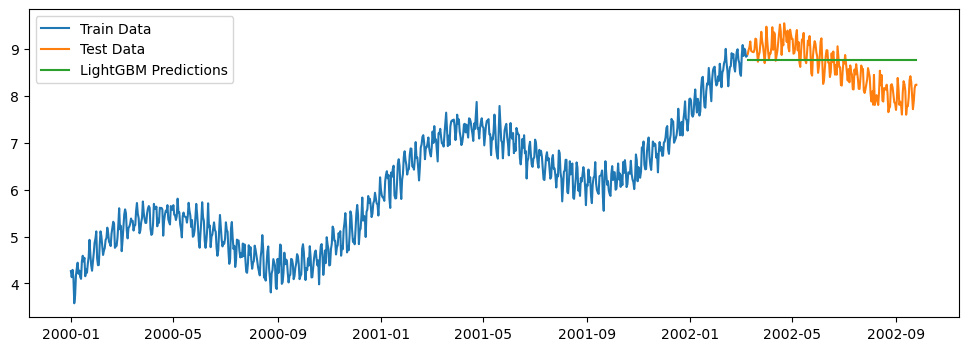

In [77]:
params = {'verbose': -1, 'num_leaves': 55, 'min_gain_to_split': 0.06764624350073846, 'metric': 'l2', 'learning_rate': 0.32486093534861593, 'lambda_l2': 0.35299651007555277, 'lambda_l1': 0.10706850623011366, 'feature_fraction': 0.8261402761937192, 'boosting_type': 'gbdt', 'bagging_fraction': 0.843250629681239}
gbm = lgb.train(params, lgb.Dataset(X, y))

X_test = pd.DataFrame(index=test.index)  # Create an empty DataFrame for test features
for lag in range(1, 5):
    X_test[f't_{lag}'] = 0.0  # Initialize the lag columns for the test data

# Fill the initial lag values in the test dataframe based on the last values in the training data
last_train_values = lgb_train.iloc[-1][['t_1', 't_2', 't_3', 't_4']].values
X_test.iloc[0, :] = last_train_values

predictions = []

# Recursive prediction for len(test) iterations
for i in range(len(test)):
    # Make a prediction for the current test instance
    pred = gbm.predict(X_test.iloc[[i]])[0]
    predictions.append(pred)
    
    # Prepare the next row of X_test by shifting the lag values
    if i + 1 < len(test):
        X_test.iloc[i + 1, 1:] = X_test.iloc[i, :-1].values  # Shift the lag features
        X_test.iloc[i + 1, 0] = pred  # Add the new prediction as the most recent lag feature

# Convert predictions list to a pandas series to plot
predictions_series = pd.Series(predictions, index=test.index)

plt.plot(train, label='Train Data')
plt.plot(test.index, test, label='Test Data')
plt.plot(test.index, predictions, label=f'LightGBM Predictions')
plt.legend()
plt.show()

2000-01-01    2.257995
2000-01-02    2.122427
2000-01-03    2.274317
2000-01-04    2.103637
2000-01-05    1.550280
                ...   
2002-09-21         NaN
2002-09-22         NaN
2002-09-23         NaN
2002-09-24         NaN
2002-09-25         NaN
Freq: D, Length: 999, dtype: float64

Detrending the training data

In [106]:
lgb_train = (train - df.iloc[:len(train)]['trend']).to_frame()
lgb_test = (test - df.iloc[len(train):]['trend']).to_frame()
lgb_train = lgb_train.rename(columns={0: 'y'})
lgb_test = lgb_test.rename(columns={0: 'y'})

for lag in range(1, 5):
    lgb_train[f't_{lag}'] = lgb_train['y'].shift(lag)

X = lgb_train.drop('y', axis=1)
y = lgb_train['y']

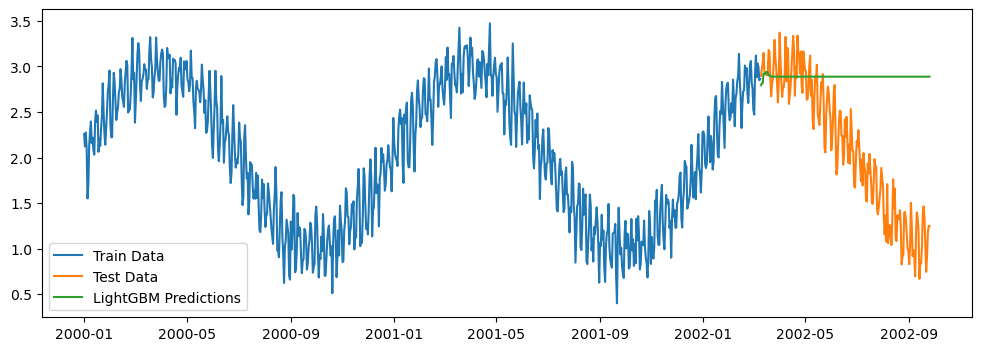

In [155]:
params = {'verbose': -1, 'num_leaves': 55, 'min_gain_to_split': 0.06764624350073846, 'metric': 'l2', 'learning_rate': 0.32486093534861593, 'lambda_l2': 0.35299651007555277, 'lambda_l1': 0.10706850623011366, 'feature_fraction': 0.8261402761937192, 'boosting_type': 'gbdt', 'bagging_fraction': 0.843250629681239}
gbm = lgb.train(params, lgb.Dataset(X, y))

X_test = pd.DataFrame(index=test.index)  # Create an empty DataFrame for test features
for lag in range(1, 5):
    X_test[f't_{lag}'] = 0.0  # Initialize the lag columns for the test data

# Fill the initial lag values in the test dataframe based on the last values in the training data
last_train_values = lgb_train.iloc[-1][['t_1', 't_2', 't_3', 't_4']].values
X_test.iloc[0, :] = last_train_values

predictions = []

# Recursive prediction for len(test) iterations
for i in range(len(test)):
    # Make a prediction for the current test instance
    pred = gbm.predict(X_test.iloc[[i]])[0]
    predictions.append(pred)
    
    # Prepare the next row of X_test by shifting the lag values
    if i + 1 < len(test):
        X_test.iloc[i + 1, 1:] = X_test.iloc[i, :-1].values  # Shift the lag features
        X_test.iloc[i + 1, 0] = pred  # Add the new prediction as the most recent lag feature

# Convert predictions list to a pandas series to plot
predictions_series = pd.Series(predictions, index=test.index)

plt.plot(lgb_train.index, lgb_train.y, label='Train Data')
plt.plot(lgb_test.index, lgb_test.y, label='Test Data')
plt.plot(lgb_test.index, predictions, label=f'LightGBM Predictions')
plt.legend()
plt.show()

,data,t_1,t_2,t_3,t_4
0,1.000000,NaN,NaN,NaN,NaN
1,1.054979,1.000000,NaN,NaN,NaN
2,1.109833,1.054979,1.000000,NaN,NaN
3,1.164438,1.109833,1.054979,1.000000,NaN
4,1.218669,1.164438,1.109833,1.054979,1.0


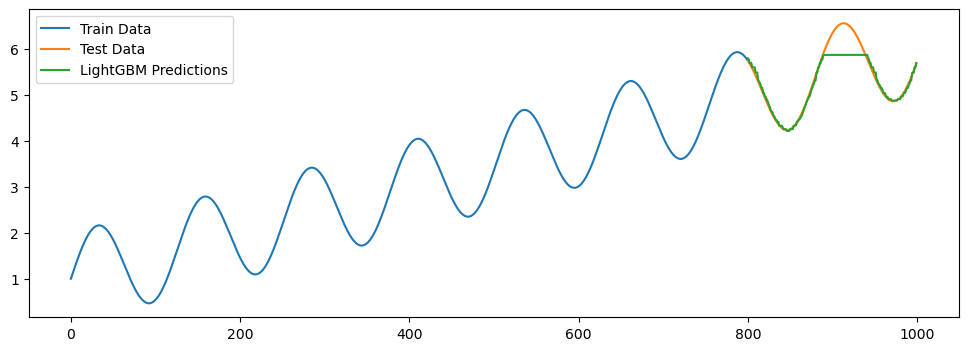

In [105]:
for lag in range(1, 5):
    df[f't_{lag}'] = df['data'].shift(lag)

X = df.drop('data', axis=1)
y = df['data']

X_train, X_test = X[:train_size], X[train_size:] 
y_train, y_test = y[:train_size], y[train_size:] 

display(df.head())

params = {'bagging_fraction': 0.5, 'boosting_type': 'gbdt', 'feature_fraction': 0.9, 'lambda_l1': 0, 'lambda_l2': 0.2, 'learning_rate': 0.2, 'metric': 'l2', 'min_gain_to_split': 0.01, 'num_leaves': 20, 'objective': 'regression', 'verbose': -1}
lgb_train = lgb.Dataset(X_train, y_train)
gbm = lgb.train(params, lgb_train)
predictions = gbm.predict(X_test)

plt.plot(train, label='Train Data')
plt.plot(np.arange(train_size, data_size), test, label='Test Data')
plt.plot(np.arange(train_size, data_size), predictions, label=f'LightGBM Predictions')
plt.legend()
plt.show()

### Neural Networks <a name="neural-networks"></a>
Below is a simple example of using a single RNN layer.

In [126]:
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from pytorch_lightning import LightningModule, Trainer
from torch import nn

class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data.iloc[idx:idx + self.seq_length].values
        y = self.data.iloc[idx + self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

class RNNModel(LightningModule):
    def __init__(self, input_size, hidden_size, output_size, seq_length):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(self.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x.unsqueeze(-1))
        loss = F.mse_loss(y_hat, y.unsqueeze(-1))
        # self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

def predict(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for x, _ in data_loader:
            x = x.unsqueeze(-1).to(model.device)
            pred = model(x)
            predictions.append(pred.item())
    return predictions

# Hyperparameters
seq_length = 20  # Number of time steps to look back
batch_size = 4
hidden_size = 50
num_layers = 1
learning_rate = 0.001
num_epochs = 20

train_dataset = TimeSeriesDataset(train, seq_length)
test_dataset = TimeSeriesDataset(test, seq_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model = RNNModel(input_size=1, hidden_size=50, output_size=1, seq_length=seq_length)
trainer = Trainer(max_epochs=20, log_every_n_steps=20)
trainer.fit(model, train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type   | Params | Mode 
----------------------------------------
0 | rnn  | RNN    | 2.6 K  | train
1 | fc   | Linear | 51     | train
----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode
c:\Users\eric_\miniconda3\envs\py3115\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [124]:
test_dataset = TimeSeriesDataset(pd.concat([train.iloc[-20:], test]), seq_length)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

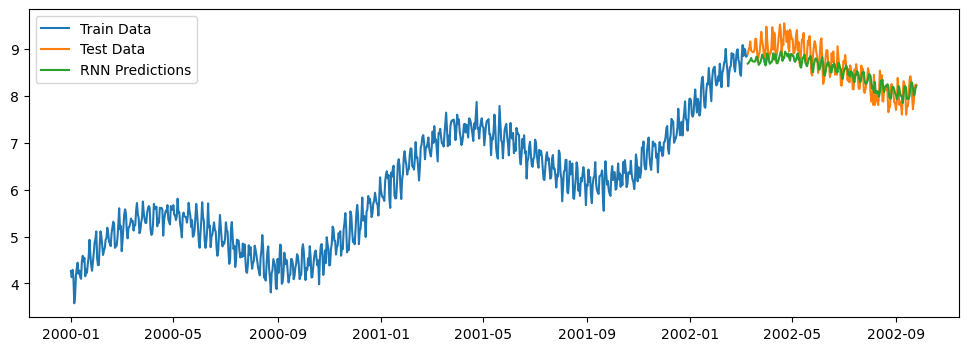

In [125]:
# predictions = predict(model, test_loader, seq_length)
plt.plot(train, label='Train Data')
plt.plot(test.index, test, label='Test Data')
plt.plot(test.index, predict(model, test_loader), label='RNN Predictions')
plt.legend()
plt.show()

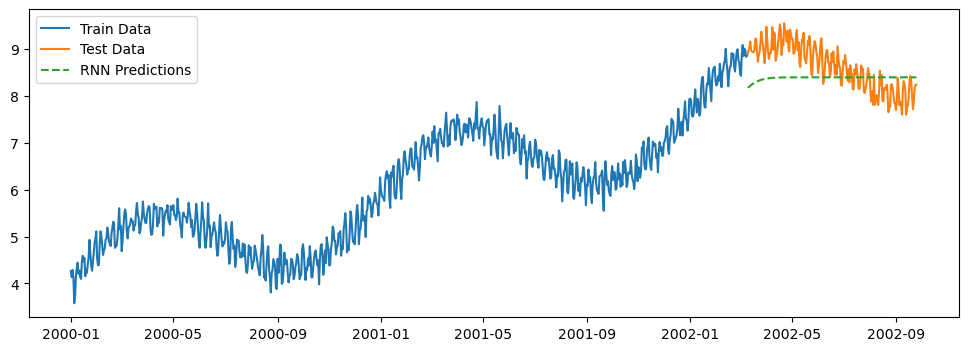

In [131]:
def predict_recursive(model, data, seq_length, steps):
    """
    Perform recursive prediction on unseen data.
    
    Args:
        model: Trained RNN model.
        data: The known data (training + test) to use for starting the prediction.
        seq_length: Number of timesteps used for each input sequence.
        steps: How many future time steps to predict.
    
    Returns:
        A list of recursive predictions.
    """
    model.eval()  # Set model to evaluation mode
    predictions = []
    
    # Start with the last `seq_length` data points from the known data
    input_seq = torch.tensor(data[-seq_length:].values, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(model.device)

    with torch.no_grad():
        for _ in range(steps):
            # Predict the next value
            pred = model(input_seq)
            
            # pred should be of shape (batch_size, 1) after model output, so we reshape it to (1, 1, 1)
            pred = pred.unsqueeze(-1)  # Add feature dimension
            
            predictions.append(pred.item())
            
            # Prepare the input sequence for the next prediction
            next_input = pred  # Predicted value is already in the correct shape
            input_seq = torch.cat((input_seq[:, 1:, :], next_input), dim=1)  # Shift the window by 1 step
            
    return predictions

# Predict future values beyond the known test set
future_steps = len(test)  # Number of future predictions to make
predicted_future_values = predict_recursive(model, pd.concat([train, test]), seq_length, future_steps)

# Plot the predictions
plt.plot(train, label='Train Data')
plt.plot(test.index, test, label='Test Data')
plt.plot(test.index, predicted_future_values, label='RNN Predictions', linestyle='--')
plt.legend()
plt.show()


## Matrix Profiles  <a name="Matrix-Profiles"></a>
* [Stumpy Documentation](https://stumpy.readthedocs.io/en/latest/#)
* [10 Things to Do with Matrix Profiles](https://www.cs.ucr.edu/~eamonn/Top_Ten_Things_Matrix_Profile.pdf)

The idea here is that we find the nearest neighbor in the time series based on euclidean distance. We split the data into "windows" that are just smaller chunks of data. For example, if you had daily data and wanted to compare weekly trends, you'd use a window of size 7.

The lowest values are considered a motif (pattern) since they represent the pair of nearest neighbor subsequences with the smallest z-normalized Euclidean distance.

The subsequences that have the highest local values are unique.

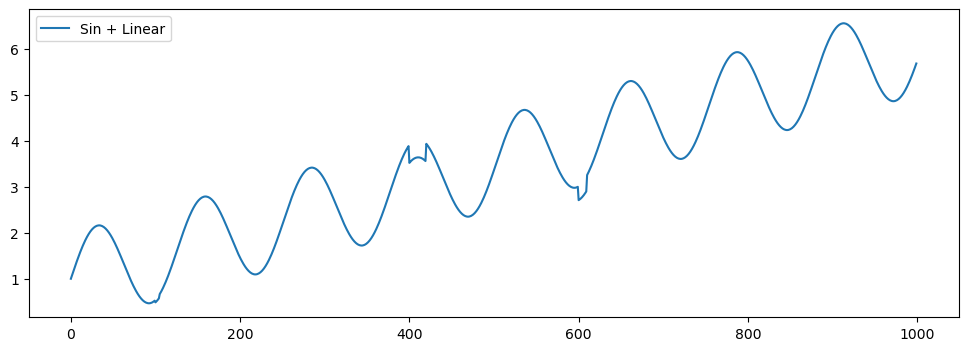

In [74]:
import stumpy
from matplotlib.patches import Rectangle

anomoly_data = data.copy()
for start, end in [(100, 105), (400, 420), (600, 610)]:
    anomoly_data[start:end] = anomoly_data[start:end] * 0.9

plt.figure(figsize=FIGSIZE)
plt.plot(anomoly_data, label='Sin + Linear')
plt.legend()
plt.show()

m = 20 # Originally tried using m = window_size = 126, but this wasn't ideal
matrix_profile = stumpy.stump(anomoly_data, m=10) 

# the first column consists of the matrix profile, 
# the second column consists of the matrix profile indices, 
# the third column consists of the left matrix profile indices, 
# the fourth column consists of the right matrix profile indices.
# mp_df = pd.DataFrame({
#     "matrix_profile": matrix_profile[:,0],
#     "indices": matrix_profile[:,1],
#     "left_indices": matrix_profile[:,2],
#     "right_indices": matrix_profile[:,3]
# })

### Motif / Pattern
The matrix profile allows you to find patterns and also the nearest neighbor for all subsequences.

The motif is located at index 498
The nearest neighbor is located at index 875


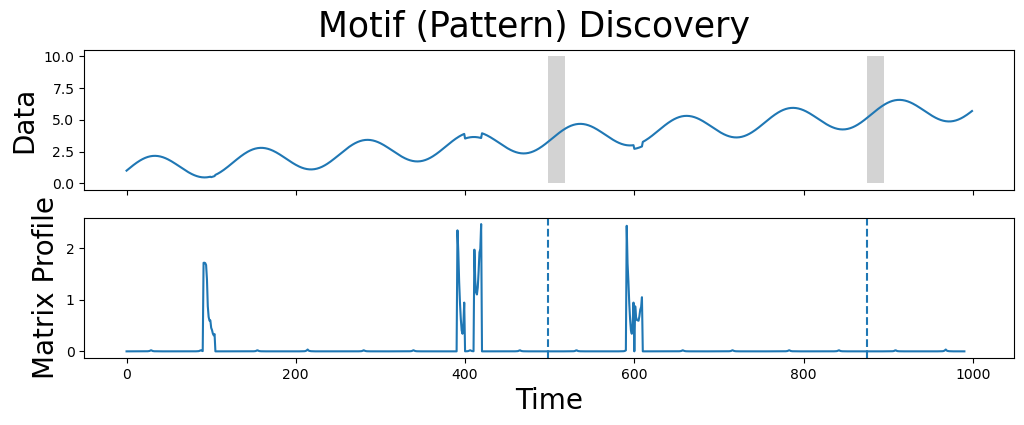

In [77]:
motif_idx = np.argsort(matrix_profile[:, 0])[0]
print(f"The motif is located at index {motif_idx}")

nearest_neighbor_idx = matrix_profile[motif_idx, 1]
print(f"The nearest neighbor is located at index {nearest_neighbor_idx}")

fig, axs = plt.subplots(2, figsize=(12, 4), sharex=True)
plt.suptitle('Motif (Pattern) Discovery', fontsize='25')
axs[0].plot(anomoly_data)
axs[0].add_patch(Rectangle((motif_idx, 0), m, 10, facecolor='lightgrey'))
axs[0].add_patch(Rectangle((nearest_neighbor_idx, 0), m, 10, facecolor='lightgrey'))
axs[0].set_ylabel('Data', fontsize='20')
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].axvline(x=motif_idx, linestyle="dashed")
axs[1].axvline(x=nearest_neighbor_idx, linestyle="dashed")
axs[1].plot(matrix_profile[:, 0])
plt.show()

### Potential Anomolies
The subsequence located at this global maximum is referred to as a discord, novelty, or potential anomaly.

The discord is located at index 419
The nearest neighbor subsequence to this discord is 2.459451015269966 units away


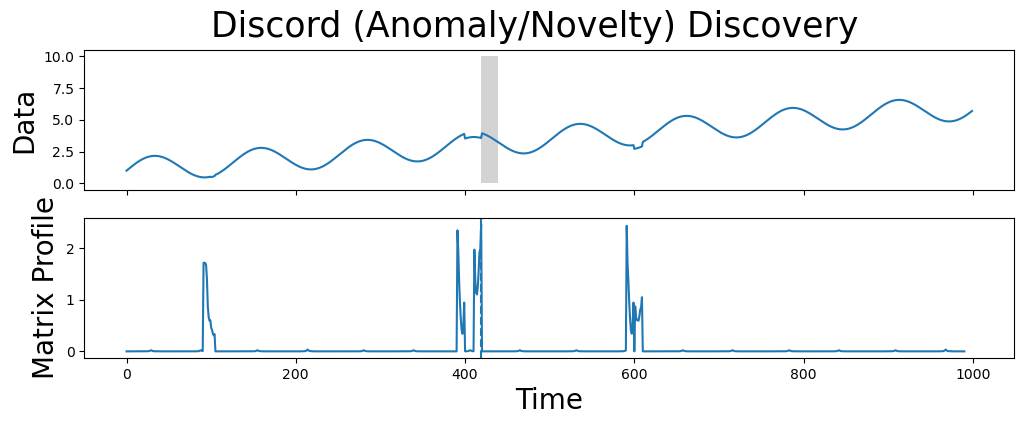

In [78]:
discord_idx = np.argsort(matrix_profile[:, 0])[-1]
print(f"The discord is located at index {discord_idx}")

nearest_neighbor_distance = matrix_profile[discord_idx, 0]
print(f"The nearest neighbor subsequence to this discord is {nearest_neighbor_distance} units away")

fig, axs = plt.subplots(2, figsize=(12, 4), sharex=True)
plt.suptitle('Discord (Anomaly/Novelty) Discovery', fontsize='25')
axs[0].plot(anomoly_data)
axs[0].set_ylabel('Data', fontsize='20')
axs[0].add_patch(Rectangle((discord_idx, 0), m, 10, facecolor='lightgrey'))
axs[1].set_xlabel('Time', fontsize ='20')
axs[1].set_ylabel('Matrix Profile', fontsize='20')
axs[1].axvline(x=discord_idx, linestyle="dashed")
axs[1].plot(matrix_profile[:, 0])
plt.show()

## Box-Cox Transformation <a name="box-cox"></a>
Transforms the target variable so that data resembles a normal distribution which is assumed by many models.

Cons:
* Harder to interprete
* Usually gives the median of the forecast distribution when we revert the transformed data to its original scale.

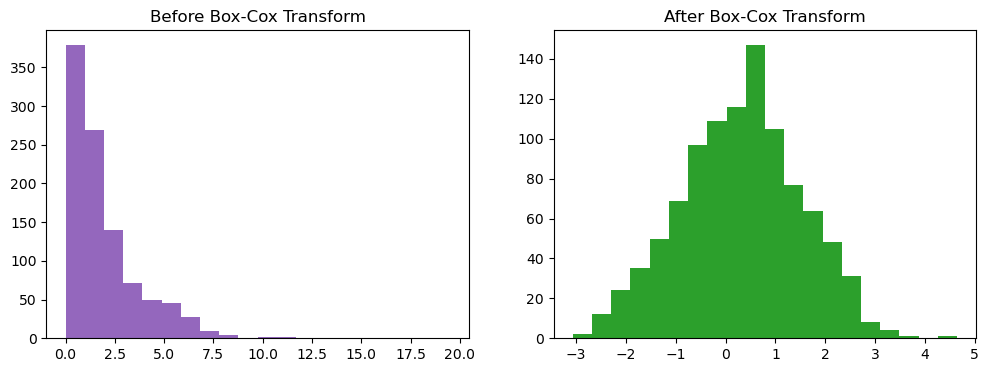

In [167]:
data = rng.exponential(scale=2, size=1000)
transformed_data, lambda_best = stats.boxcox(data)

plt.subplot(1, 2, 1)
plt.hist(data, bins=20, color='tab:purple')
plt.title("Before Box-Cox Transform")

plt.subplot(1, 2, 2)
plt.hist(transformed_data, bins=20, color='tab:green')
plt.title("After Box-Cox Transform")
plt.show()

## Portmanteau Test <a name="Portmanteau-Test"></a>
Hypothesis test for the presence of autocorrelation. 

## Ljung-Box Test
[Ljung-Box test of autocorrelation in residuals](https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html) is commonly applied to the residuals of a time series model, such as ARIMA or other time series models, to test whether they are independent (i.e., no autocorrelation remains in the residuals).

A p-value is greater than 0.05 implies that no significant autocorrelation remains in the residuals, and the model is a good fit from the perspective of autocorrelation.

In [172]:
ljung_box_result = acorr_ljungbox(train, lags=[7, 14, 365], return_df=True)


# lb_stat: The Ljung-Box test statistic.
# lb_pvalue: The p-value associated with the test statistic. 
#              A small p-value (typically less than 0.05) would lead to rejection of the null hypothesis, indicating that significant autocorrelation exists at the tested lags.

print(ljung_box_result)

          lb_stat  lb_pvalue
7     5004.563971        0.0
14    9648.760599        0.0
365  43432.463826        0.0


## References
* [Forecasting: Principles and Practice](https://otexts.com/fpp3/)
* [ARIMA models for time series forecasting](https://people.duke.edu/~rnau/411arim.htm#pdq)
* [statsmodels.org](https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html)
* [LightGBM](https://lightgbm.readthedocs.io/en/stable/Parameters-Tuning.html)